In [1]:
#import needed packages

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import time
from ecp import e_divisive
%matplotlib inline

In [2]:
def return_state_ts(hs_mean=0, hs_stay_p = 0.99, away_stay_p = 0.97, sigma = 1, n = 1000):
    ts = np.zeros(n)
    in_hs = True
    
    away_low = 3
    away_high = 10
    
    away_mean = np.random.uniform(away_low, away_high)
    for i in range(n):
        noise = np.random.normal(0, sigma)
        if in_hs:
            ts[i] = hs_mean + noise
            if np.random.uniform(0, 1) > hs_stay_p:
                in_hs = False
                away_mean = np.random.uniform(away_low, away_high)
        else:
            ts[i] = away_mean + noise
            if np.random.uniform(0, 1) > away_stay_p:
                in_hs = True
    return ts

In [23]:
def MCTS(ts, K, ms, num_of_states, alpha=0, home=False):
    sol_dict = e_divisive.e_divisive(X = np.reshape(ts, (len(ts), 1)), k=K, alpha=2, min_size=ms)

    clusters = sol_dict['cluster']
    num_of_clusters = clusters[-1]+1

    find_means = np.vectorize(lambda x : np.mean(ts[clusters == x]))
    cluster_means = find_means(np.arange(num_of_clusters))

    sort_c_idx = np.argsort(cluster_means).argsort()
    sort_c = np.sort(cluster_means)

    sol_dict_2 = e_divisive.e_divisive(X = np.reshape(sort_c, (len(sort_c), 1)), k=num_of_states-1, alpha=2, min_size=2)

    cluster_labels = np.zeros(num_of_clusters, dtype=np.int32)
    ests = sol_dict_2['estimates']
    for i in range(1, len(ests)):
        cluster_labels[(sort_c_idx >= ests[i-1]) & (sort_c_idx < ests[i])] = i - 1

    new_ests = [sol_dict['estimates'][0]]
    new_labs = [cluster_labels[0]]
    for i in range(1, len(cluster_labels)):
        if cluster_labels[i] != cluster_labels[i-1]:
            new_ests.append(sol_dict['estimates'][i])
            new_labs.append(cluster_labels[i])
    new_ests.append(sol_dict['estimates'][-1])
    final_ests = np.array(new_ests)
    new_labs = np.array(new_labs)

    lens = np.diff(final_ests)
    find_avg_time = np.vectorize(lambda x : np.mean(lens[new_labs == x]))
    avg_times = find_avg_time(np.arange(num_of_states))

    P_diag = np.vectorize(lambda x : (x - 1)/x)(avg_times)

    est_P = np.zeros((num_of_states, num_of_states)) + alpha
    for i in range(1, len(cluster_labels)):
        est_P[cluster_labels[i-1], cluster_labels[i]] += 1
    np.fill_diagonal(est_P, 0)
    est_P = normalize(est_P, axis = 1, norm='l1')
    est_P = (est_P.T*(1 - P_diag)).T
    np.fill_diagonal(est_P, P_diag)

    final_clusters = np.repeat(np.arange(0,len(np.diff(final_ests))), np.diff(final_ests))
    find_seg_sums = np.vectorize(lambda x : np.sum(ts[final_clusters == x]))
    seg_sums = find_seg_sums(np.arange(final_clusters[-1]+1))

    find_time = np.vectorize(lambda x: np.sum(lens[new_labs == x]))
    total_times = find_time(np.arange(num_of_states))

    find_state_sums = np.vectorize(lambda x: np.sum(seg_sums[new_labs == x]))
    est_S = find_state_sums(np.arange(num_of_states))/total_times
    
    if home:
        return new_labs, final_ests
    else:
        return est_P, est_S

Text(0, 0.5, 'y_t')

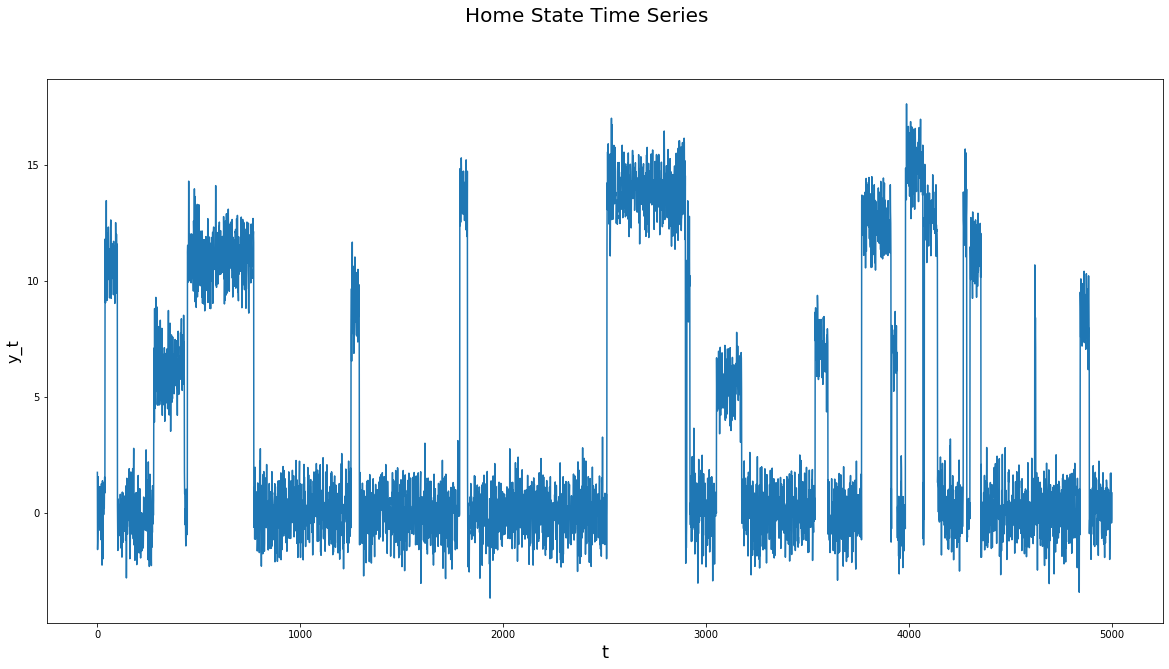

In [24]:
ts = return_state_ts(n=5000)
fig = plt.figure(figsize=(20,10))
plt.plot(ts)
fig.suptitle('Home State Time Series', fontsize=20)
plt.xlabel('t', fontsize=18)
plt.ylabel('y_t', fontsize=16)

Time Series Length: 3000
Generation took: 0.032826900482177734
MCTS took: 92.88183307647705
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


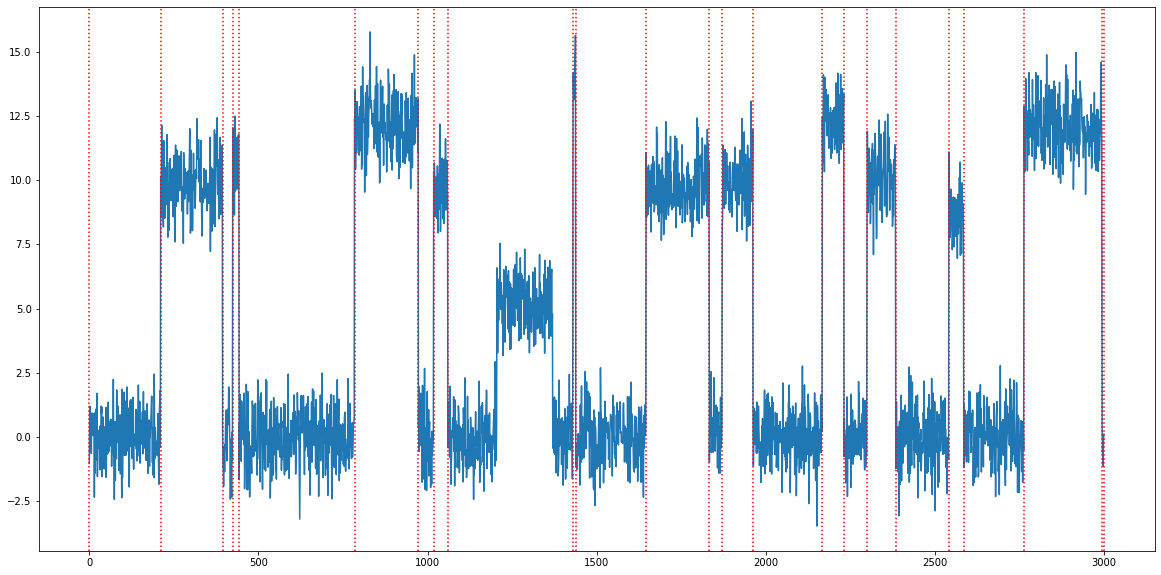

In [26]:
P = 0.99
N = 3000
K = int(N/(1/(1 - P))) + N/100
ms = 2
num_of_states = 2 #len(S)

t1 = time.time()
ts = return_state_ts(hs_stay_p = P, n=N)
t2 = time.time()

clus, ests = MCTS(ts, K, ms, num_of_states, home=True)
t3 = time.time()

print("Time Series Length: " + str(N))
print("Generation took: " + str(t2 - t1))
print("MCTS took: " + str(t3 - t2))
plt.figure(figsize=(20,10))
plt.plot(ts)
print(clus)
for xc in ests:
    plt.axvline(x=xc, color='r', linestyle=':')